In [1]:
from htmd.ui import *
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import pandas as pd
from sksurv.nonparametric import kaplan_meier_estimator


2023-07-04 16:58:13,083 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
/Users/toni/Apps/anaconda-m1/lib/python3.9/site-packages/conda/models/match_spec.py:773: UserWarning: 'name' specified both inside (htmd) and outside (*) of brackets. the value outside of brackets ({components['name']}) will be used.
  warnings.warn(


You are on the latest HTMD version (unpackaged : /Users/toni/Apps/anaconda-m1/envs/htmd/lib/python3.10/site-packages/htmd).



Box is 60 * 66 * 98 A

flat bottom box (smooth surface, 40 × 40 × 60 Å3)

Original paper
kon = (1.6 ± 0.8) × 106 M−1 s−1 (95% confidence interval: 0.6−3.7 × 106 M−1 s−1

c = 20 mM

Panayotou et aL, 1993; Bu et aL, 1995; Ladbury et al., 1995; Morelock
et al., 1995; BorrelIo et al., 1996). Typicaily, dissociation constants (Kd)were found of
< 20 nM, association rate constants (ka)of 1.4 x 104 to 2.5 X 106 M-1s-l 
https://tspace.library.utoronto.ca/bitstream/1807/12312/1/NQ35322.pdf



In [2]:
nc_metric= MetricData()
nc_metric.load('metrics/nc.htmd')

rmsd_metric= MetricData()
rmsd_metric.load("metrics/rmsd.htmd")

conc = 0.02


In [4]:
def metricData2pandas(md):
    ll=[]
    for i in range(len(md.dat)):
        mval=md.dat[i]
        tname = md.trajectories[i].sim.trajectory[0]
        nf=md.trajectories[i].sim.numframes
        #ll.append({"Trajectory": tname, "Data": mval})
        tmp = pd.DataFrame(mval)
        tmp["Trajectory"]=tname
        tmp["TrajID"]=i
        tmp["Frame"]=tmp.reset_index().index
        ll.append(tmp)
    ld = pd.concat(ll)
    ld = ld.loc[ld.Frame<=800]
    return ld

In [7]:
def df2sens(df, thrs, column, less_is_bound=False):
    df=df.copy(deep=True)
    sens = []
    for thr in thrs:
        df["Bound"]=df[column]<=thr if less_is_bound else df[column]>=thr 
        tmp=df.groupby("Frame")["Bound"].mean()
        sens.append(pd.DataFrame({
            "Threshold": thr,
            "Time": tmp.index,
            "Bound": tmp.values,
            "Unbound": 1-tmp.values
        }))
    sens = pd.concat(sens)
    return sens


def plot_sens(nc_sens):
    nc_thrs = np.unique(nc_sens.Threshold)
    colors = pl.cm.jet(np.linspace(0,1,len(nc_thrs)))
    for i,thr in enumerate(nc_thrs):
        pl.plot(nc_sens.loc[nc_sens.Threshold==thr,"Unbound"], 
                color=colors[i], label=f"{thr:.02f}")
        pl.ylim(0,1.1)
    pl.legend(loc="lower left", ncol=3)
    pl.xlabel("Time (ns)")
    pl.ylabel("Unbound fraction")

In [188]:
def df2surv(df, thrs, column, less_is_bound=False):
    surv=[]
    df=df.copy(deep=True)
    for thr in thrs:
        df["Bound"]=df[column]<=thr if less_is_bound else df[column]>=thr 
        dft = df.groupby("Trajectory")
        for trn,trdf in dft:
            tmp = (False, trdf["Frame"].max())
            mintbound = trdf.loc[trdf["Bound"],"Frame"].min()
            if not np.isnan(mintbound):
                tmp = (True, mintbound)
            surv.append({"Threshold": thr,
                         "Status": tmp[0],
                         "Time": tmp[1]})
    surv = pd.DataFrame(surv)
    return surv
        
def ulmCI(k):
    import scipy
    return np.array([scipy.stats.chi2.ppf(.025,2*k)/2, 
                     scipy.stats.chi2.ppf(.975,2*(k+1))/2])


def plot_surv(rmsd_surv_all):
    i = 0
    nc_thrs = np.unique(rmsd_surv_all.Threshold)
    colors = pl.cm.jet(np.linspace(0,1,len(nc_thrs)))
    for thr, rmsd_surv in rmsd_surv_all.groupby("Threshold"):
        time, survival_prob, conf_int = kaplan_meier_estimator(
            rmsd_surv["Status"], rmsd_surv["Time"], conf_type="log-log"
        )
        plt.step(time, survival_prob, where="post",
                color=colors[i], label=thr)
        plt.fill_between(time, conf_int[0], conf_int[1],
                        color=colors[i],
                        alpha=0.25, step="post")
        i=i+1
    plt.ylim(0, 1)
    plt.ylabel("Est. probability of survival $\hat{S}(t)$")
    plt.xlabel("Time before first binding (ns)")
    plt.legend(loc="lower left", ncol=3)

def surv2rates(rmsd_surv_all):
    unit = 1e6
    rmsd_rates = []
    for thr, rmsd_surv in rmsd_surv_all.groupby("Threshold"):
        nev = rmsd_surv["Status"].sum() 
        totT = rmsd_surv["Time"].sum()/1e9 # ns to seconds 
        ulm = ulmCI(nev)
        rmsd_rates.append({"Threshold": thr, 
                        "nev": nev,
                        "totT": totT,
                        "kon": nev/totT/conc/unit,
                        "klow": ulm[0]/totT/conc/unit,
                        "khigh": ulm[1]/totT/conc/unit})
    rmsd_rates=pd.DataFrame(rmsd_rates)
    rmsd_rates["Dklow"]=rmsd_rates.kon-rmsd_rates.klow
    rmsd_rates["Dkhigh"]=rmsd_rates.khigh-rmsd_rates.kon
    return rmsd_rates
 

In [6]:
rmsd_df=metricData2pandas(rmsd_metric)
rmsd_df

,0,Trajectory,TrajID,Frame
0,52.621304,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,0
1,52.279541,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,1
2,55.513489,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,2
3,53.579525,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,3
4,44.058643,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,4
...,...,...,...,...
789,7.665262,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,789
790,8.433656,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,790
791,7.681581,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,791
792,7.552290,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,792


# Native contacts
## Sensitivity analysis

In [5]:
nc_df=metricData2pandas(nc_metric)
nc_df["NCF"]=nc_df[0]/328
nc_df

,0,Trajectory,TrajID,Frame,NCF
0,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,0,0.000000
1,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,1,0.000000
2,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,2,0.000000
3,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,3,0.000000
4,0.000000,/Users/toni/work/sh2-reconstructed/traj/s0r1/s...,0,4,0.000000
...,...,...,...,...,...
789,12.776513,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,789,0.038953
790,12.624059,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,790,0.038488
791,13.762786,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,791,0.041960
792,23.518974,/Users/toni/work/sh2-reconstructed/traj/s0r800...,771,792,0.071704


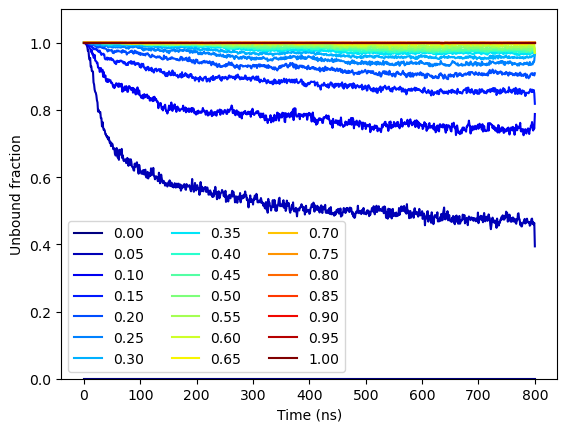

In [202]:
nc_thrs = np.linspace(0,1,21)
#nc_thrs = [.05, .1, .2, .3, .4]

nc_sens = df2sens(nc_df, nc_thrs, "NCF")
plot_sens(nc_sens)


## Survival curves

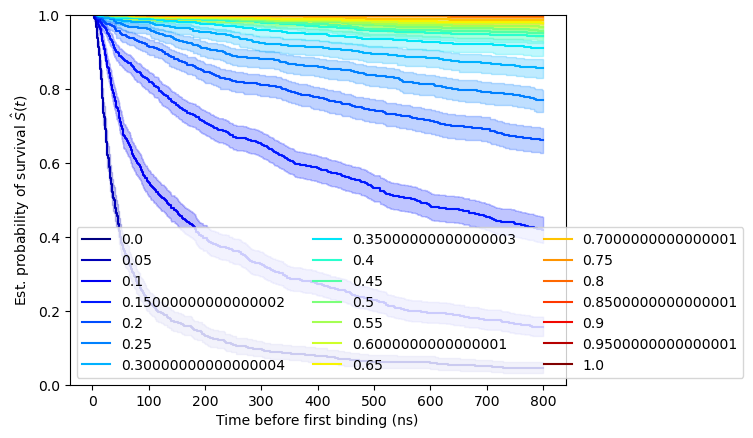

In [203]:
nc_surv_all = df2surv(nc_df, nc_thrs, "NCF")
plot_surv(nc_surv_all)

/var/folders/qz/7p0f8wdj4zdd8nwxm89xzhy80000gn/T/ipykernel_54738/1804950318.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  "kon": nev/totT/conc/unit,
/var/folders/qz/7p0f8wdj4zdd8nwxm89xzhy80000gn/T/ipykernel_54738/1804950318.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  "klow": ulm[0]/totT/conc/unit,
/var/folders/qz/7p0f8wdj4zdd8nwxm89xzhy80000gn/T/ipykernel_54738/1804950318.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  "khigh": ulm[1]/totT/conc/unit})


ValueError: 'yerr' (shape: (2, 21)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (10,))

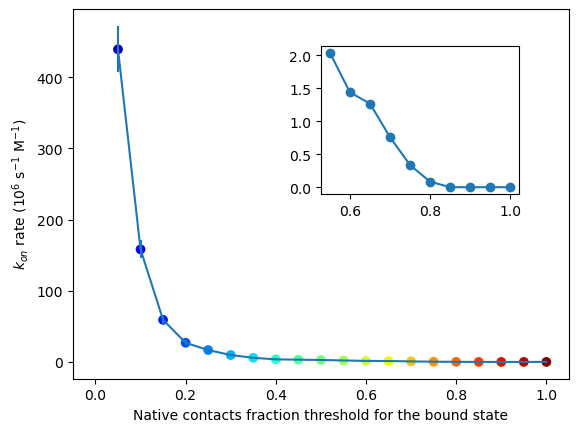

In [209]:
nc_rates = surv2rates(nc_surv_all)
rates = nc_rates

colors = pl.cm.jet(np.linspace(0,1,len(rates)))
ax=plt.subplot(1,1,1)
ax.scatter(rates.Threshold, rates.kon, color=colors)
rerr = rates.iloc[:,6:8].to_numpy().T
ax.errorbar(rates.Threshold, rates.kon, yerr=rerr)
ax.set_xlabel("Native contacts fraction threshold for the bound state")
ax.set_ylabel("$k_{on}$ rate ($10^6$ s$^{-1}$ M$^{-1}$)")

ax2 = ax.inset_axes([.5, .5, .4, .4 ])
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
rates_ss = rates.loc[rates.Threshold>0.4]
ax2.scatter(rates_ss.Threshold, rates_ss.kon)
ax2.errorbar(rates_ss.Threshold, rates_ss.kon, yerr=rerr)

# RMSD

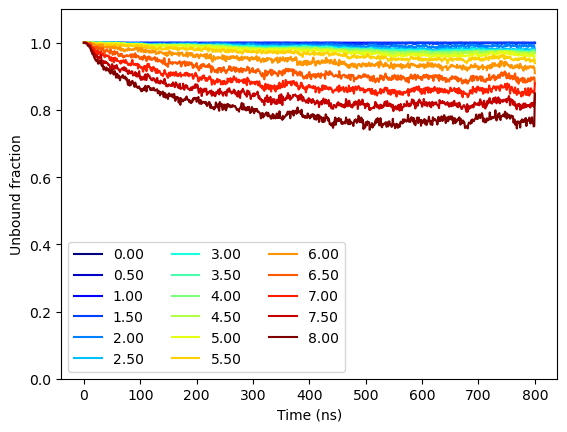

In [182]:
rmsd_thrs = np.linspace(0,8,17)
rmsd_sens = df2sens(rmsd_df, rmsd_thrs, 0, less_is_bound=True)

plot_sens(rmsd_sens)


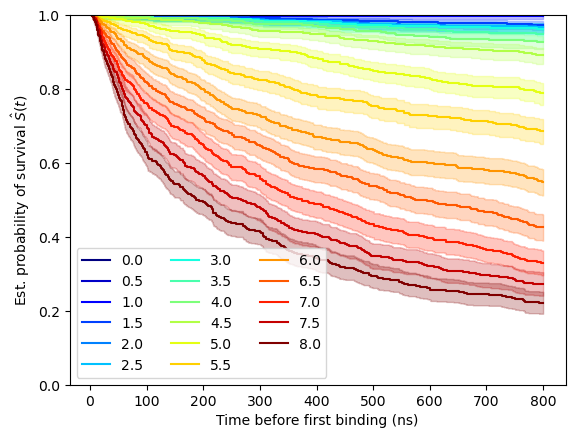

In [184]:
rmsd_surv_all = df2surv(rmsd_df, rmsd_thrs, 0, less_is_bound=True)
plot_surv(rmsd_surv_all)


In [190]:
len(rmsd_rates)

17

<ErrorbarContainer object of 3 artists>

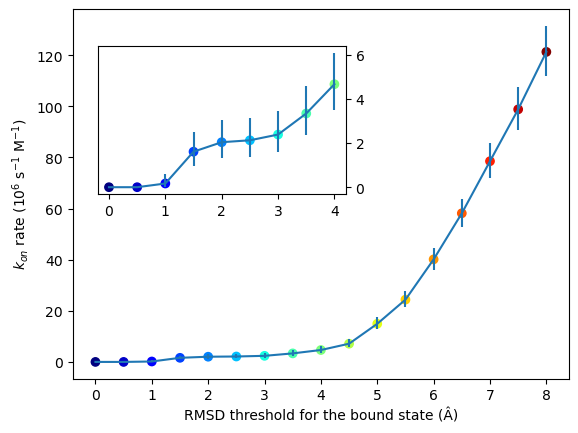

In [191]:
rmsd_rates = surv2rates(rmsd_surv_all)
colors = pl.cm.jet(np.linspace(0,1,len(rmsd_rates)))

ax=plt.subplot(1,1,1)
ax.scatter(rmsd_rates.Threshold, rmsd_rates.kon, color=colors)
rerr = rmsd_rates.iloc[:,6:8].to_numpy().T
ax.errorbar(rmsd_rates.Threshold, rmsd_rates.kon, yerr=rerr)
ax.set_xlabel("RMSD threshold for the bound state (Â)")
ax.set_ylabel("$k_{on}$ rate ($10^6$ s$^{-1}$ M$^{-1}$)")
ax2 = ax.inset_axes([.05, .5, .5, .4 ])
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.scatter(rmsd_rates.Threshold[0:9], rmsd_rates.kon[0:9], color=colors[0:9])
ax2.errorbar(rmsd_rates.Threshold[0:9], 
             rmsd_rates.kon[0:9], yerr=rerr[:,0:9])
# plt.ylim(0,1e-3)

In [166]:
19/0.000591/conc

1607445.0084602367